In [279]:
from collections import OrderedDict
import re
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from tqdm.notebook import tqdm

from eval import get_run_metrics, read_run_dir, get_model_from_run, get_parrallel_model_from_run
from plot_utils import basic_plot, collect_results, relevant_model_names

%matplotlib inline
%load_ext autoreload
%autoreload 2

sns.set_theme('notebook', 'darkgrid')
palette = sns.color_palette('colorblind')

run_dir = "../models"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [257]:
df = read_run_dir(run_dir)
df  # list all the runs in our run_dir

,run_id,task,model,kwargs,num_tasks,num_examples,n_dims,n_layer,n_head,run_name
4,pretrained,decision_tree,Transformer,depth=4,-1,-1,20,12,8,decision_tree_pretrained
1,pretrained,linear_regression,Transformer,,-1,-1,20,12,8,linear_regression_pretrained
2,b009628e-26b5-4f2a-8f84-df84e0565587,linear_regression,Transformer,,-1,-1,20,12,8,linear_regression_standard
8,first,multiple_task_with_label,multiple_task_with_label_standard,,-1,-1,20,12,8,multiple_task_with_label_standard
6,first,multiple_task_with_label_adjust_loss_weight,multiple_task_with_label_standard_adjust_loss_...,,-1,-1,20,12,8,multiple_task_with_label_standard_adjust_loss_...
0,first,multiple_task_without_label,Transformer,,-1,-1,20,12,8,multiple_task_without_label_standard
3,first,multiple_task_without_label_adjust_loss_weight,Transformer,,-1,-1,20,12,8,multiple_task_without_label_standard_adjust_lo...
5,pretrained,relu_2nn_regression,Transformer,hidden_layer_size=100,-1,-1,20,12,8,relu_2nn_regression_pretrained
7,pretrained,sparse_linear_regression,Transformer,sparsity=3,-1,-1,20,12,8,sparse_regression_pretrained


In [280]:
# task = "linear_regression"
#task = "sparse_linear_regression"
#task = "decision_tree"
#task = "relu_2nn_regression"

model_name_without_label = "multiple_task_without_label_adjust_loss_weight"

# model_name_without_label = "multiple_task_without_label"

task_without_label = "multiple_task_without_label"

run_id = "first"  # if you train more models, replace with the run_id from the table above

run_path_without_label = os.path.join(run_dir, model_name_without_label, run_id)


In [281]:
model_name_with_label = "multiple_task_with_label_adjust_loss_weight"
# model_name_with_label = "multiple_task_with_label"

task_with_label = "multiple_task_with_label"

run_id = "first"  # if you train more models, replace with the run_id from the table above

run_path_with_label = os.path.join(run_dir, model_name_with_label, run_id)

# Plot pre-computed metrics

In [282]:
def valid_row(r):
    return r.task == task_without_label and r.run_id == run_id

metrics = collect_results(run_dir, df, valid_row=valid_row)

eval_task = ["linear_regression", ]

multiple_task_without_label_standard first


100%|██████████| 1/1 [00:00<00:00, 7002.18it/s]

In [261]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# Interactive setup

We will now directly load the model and measure its in-context learning ability on a batch of random inputs. (In the paper we average over multiple such batches to obtain better estimates.)

In [262]:
from samplers import get_data_sampler
from tasks import get_task_sampler

In [283]:
model_without_label, conf = get_parrallel_model_from_run(run_path_without_label)
model_without_label = model_without_label.to(device)
# model_with_label, conf = get_parrallel_model_from_run(run_path_with_label)
model_with_label, conf = get_parrallel_model_from_run(run_path_with_label)
model_with_label = model_with_label.to(device)

In [284]:
n_dims = conf.model.n_dims
batch_size = conf.training.batch_size * 20

data_sampler = get_data_sampler(conf.training.data, n_dims)
task_sampler = get_task_sampler(
    "linear_regression",
    n_dims,
    batch_size,
    **conf.training.task_kwargs
)

In [285]:
task = task_sampler()

xs= data_sampler.sample_xs(b_size=batch_size, n_points=60).to(device)
ys = task.evaluate(xs).to(device)

with torch.no_grad():
    pred_without_label = model_without_label(xs, ys)
with torch.no_grad():
    pred_with_label = model_with_label(xs, ys,0)

metric_without_label = task.get_metric()
loss_without_label = metric_without_label(pred_without_label, ys).cpu().numpy()

metric_with_label = task.get_metric()
loss_with_label = metric_with_label(pred_with_label, ys).cpu().numpy()

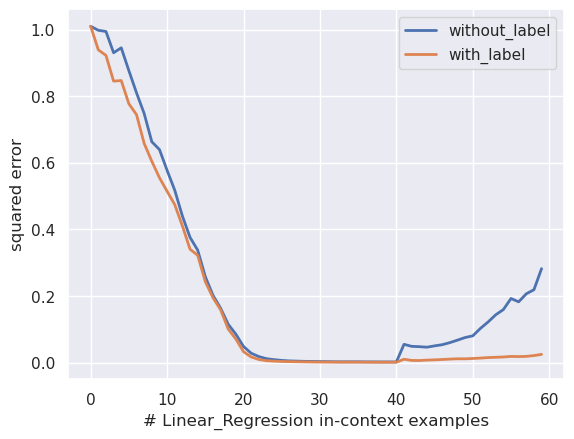

In [289]:
plt.plot(loss_without_label.mean(axis=0)/20, lw=2, label="without_label")
plt.plot(loss_with_label.mean(axis=0)/20, lw=2, label="with_label")
# plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
plt.xlabel("# Linear_Regression in-context examples")
plt.ylabel("squared error")
plt.legend()
plt.show()

In [290]:
n_dims = conf.model.n_dims
batch_size = conf.training.batch_size * 20

data_sampler = get_data_sampler(conf.training.data, n_dims)
task_sampler = get_task_sampler(
    "quadratic_regression",
    n_dims,
    batch_size,
    **conf.training.task_kwargs
)

In [291]:
task = task_sampler()

xs= data_sampler.sample_xs(b_size=batch_size, n_points=60).to(device)
ys = task.evaluate(xs).to(device)

with torch.no_grad():
    pred_without_label = model_without_label(xs, ys)
with torch.no_grad():
    pred_with_label = model_with_label(xs, ys,1)

metric_without_label = task.get_metric()
loss_without_label = metric_without_label(pred_without_label, ys).cpu().numpy()

metric_with_label = task.get_metric()
loss_with_label = metric_with_label(pred_with_label, ys).cpu().numpy()

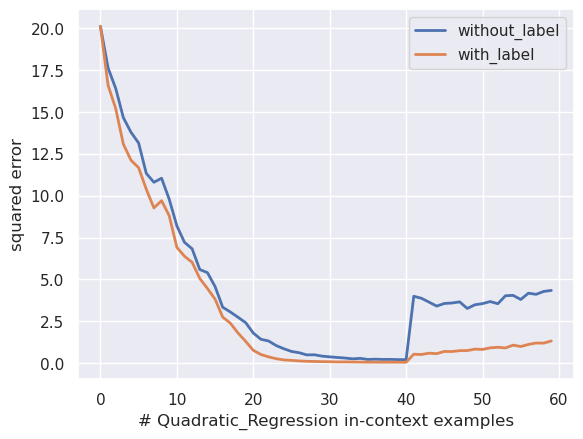

In [292]:
plt.plot(loss_without_label.mean(axis=0)/20, lw=2, label="without_label")
plt.plot(loss_with_label.mean(axis=0)/20, lw=2, label="with_label")
# plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
plt.xlabel("# Quadratic_Regression in-context examples")
plt.ylabel("squared error")
plt.legend()
plt.show()

In [270]:
n_dims = conf.model.n_dims
batch_size = conf.training.batch_size * 50

data_sampler = get_data_sampler(conf.training.data, n_dims)
task_sampler = get_task_sampler(
    "linear_classification",
    n_dims,
    batch_size,
    **conf.training.task_kwargs
)

In [271]:
task = task_sampler()

xs= data_sampler.sample_xs(b_size=batch_size, n_points=60).to(device)
ys = task.evaluate(xs).to(device)

with torch.no_grad():
    pred_without_label = model_without_label(xs, ys)
with torch.no_grad():
    pred_with_label = model_with_label(xs, ys,2)

metric_without_label = task.get_metric()
loss_without_label = metric_without_label(pred_without_label, ys).cpu().numpy()

metric_with_label = task.get_metric()
loss_with_label = metric_with_label(pred_with_label, ys).cpu().numpy()

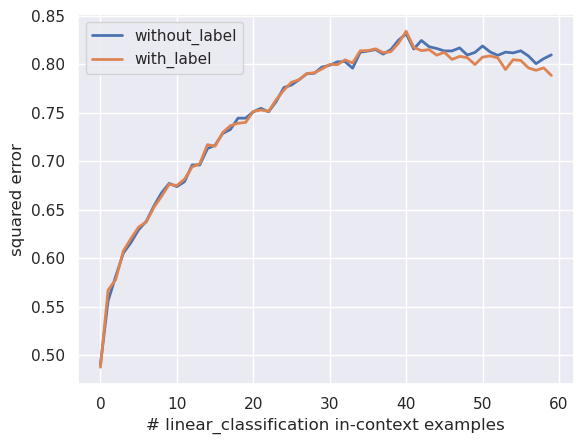

In [272]:
plt.plot(loss_without_label.mean(axis=0)/20, lw=2, label="without_label")
plt.plot(loss_with_label.mean(axis=0)/20, lw=2, label="with_label")
# plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
plt.xlabel("# linear_classification in-context examples")
plt.ylabel("squared error")
plt.legend()
plt.show()